In [7]:
#!pip install --upgrade jupyter ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [1]:
from datasets import load_dataset
import tiktoken
import h5py
from tqdm.notebook import tqdm
from torch.utils.data import IterableDataset
from collections import defaultdict

In [6]:
class PileDataset(IterableDataset):
    def __init__(self, dataset_iterator, context_length, tokenizer):
        self.dataset_iterator = dataset_iterator
        self.context_length = context_length
        self.tokenizer = tokenizer
        self.current_tokens = []
        self.current_pile_set_name = None

    def __iter__(self):
        return self

    def __next__(self):
        while len(self.current_tokens) < self.context_length:
            try:
                example = next(self.dataset_iterator)
                text = example['text'] + "<|endoftext|>"
                new_tokens = self.tokenizer.encode(text, allowed_special={'<|endoftext|>'})
                self.current_tokens.extend(new_tokens)
                self.current_pile_set_name = example['meta']['pile_set_name']
            except StopIteration:
                if not self.current_tokens:
                    raise StopIteration
                break
            except Exception as e:
                print(f"Error processing example: {e}")
                continue

        if len(self.current_tokens) >= self.context_length:
            tokens = self.current_tokens[:self.context_length]
            self.current_tokens = self.current_tokens[self.context_length:]
        else:
            tokens = self.current_tokens
            self.current_tokens = []

        return tokens, self.current_pile_set_name

In [2]:
class PileDataset(IterableDataset):
    def __init__(self, dataset_iterator, context_length, tokenizer):
        self.dataset_iterator = dataset_iterator
        self.context_length = context_length
        self.tokenizer = tokenizer
        self.current_tokens = []
        self.current_pile_set_name = None
        self.pile_set_distribution = defaultdict(int)
        self.total_tokens = 0

    def __iter__(self):
        return self

    def __next__(self):
        while len(self.current_tokens) < self.context_length:
            try:
                example = next(self.dataset_iterator)
                text = example['text'] + "<|endoftext|>"
                new_tokens = self.tokenizer.encode(text, allowed_special={'<|endoftext|>'})
                self.current_tokens.extend(new_tokens)
                self.current_pile_set_name = example['meta']['pile_set_name']
                self.pile_set_distribution[self.current_pile_set_name] += len(new_tokens)
                self.total_tokens += len(new_tokens)
            except StopIteration:
                if not self.current_tokens:
                    raise StopIteration
                break
            except Exception as e:
                print(f"Error processing example: {e}")
                continue

        if len(self.current_tokens) >= self.context_length:
            tokens = self.current_tokens[:self.context_length]
            self.current_tokens = self.current_tokens[self.context_length:]
        else:
            tokens = self.current_tokens
            self.current_tokens = []

        return tokens, self.current_pile_set_name

    def print_distribution(self):
        print("Data Distribution:")
        for pile_set, count in self.pile_set_distribution.items():
            print(f"{pile_set}: {count} tokens ({count/self.total_tokens*100:.2f}%)")

    def export_to_h5(self, output_file, chunk_size=1000000, max_tokens=None):
        with h5py.File(output_file, 'w') as f:
            dset = f.create_dataset('tokens', shape=(0,), maxshape=(None,), dtype='i4', chunks=True)
            
            total_tokens = 0
            buffer = []
            samples_processed = 0
            
            pbar = tqdm(total=max_tokens or float('inf'), desc="Processing tokens", unit="tok")
            
            try:
                for tokens, pile_set_name in self:
                    buffer.extend(tokens)
                    
                    if len(buffer) >= chunk_size:
                        dset.resize(total_tokens + len(buffer), axis=0)
                        dset[total_tokens:] = buffer
                        total_tokens += len(buffer)
                        pbar.update(len(buffer))
                        buffer = []
                    
                    samples_processed += 1

                    if max_tokens and total_tokens >= max_tokens:
                        print(f"Reached max tokens: {total_tokens}")
                        break
                    
                    if samples_processed % 1000 == 0:
                        print(f"Processed {samples_processed} samples, {total_tokens} tokens")
            
            except Exception as e:
                print(f"Error in main loop: {e}")
            
            if buffer:
                dset.resize(total_tokens + len(buffer), axis=0)
                dset[total_tokens:] = buffer
                total_tokens += len(buffer)
                pbar.update(len(buffer))
            
            pbar.close()

            # Save the distribution to the HDF5 file
            distribution_group = f.create_group('distribution')
            for pile_set, count in self.pile_set_distribution.items():
                distribution_group.attrs[pile_set] = count

        print(f"Tokenization complete. Total tokens: {total_tokens}")
        print(f"Samples processed: {samples_processed}")
        return output_file

    def split(self, train_ratio, val_ratio, test_ratio):
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
        
        train_tokens = int(self.total_tokens * train_ratio)
        val_tokens = int(self.total_tokens * val_ratio)
        test_tokens = self.total_tokens - train_tokens - val_tokens

        train_dataset = PileDataset(self.dataset_iterator, self.context_length, self.tokenizer)
        val_dataset = PileDataset(self.dataset_iterator, self.context_length, self.tokenizer)
        test_dataset = PileDataset(self.dataset_iterator, self.context_length, self.tokenizer)

        current_tokens = 0
        current_dataset = train_dataset

        for tokens, pile_set_name in self:
            if current_tokens < train_tokens:
                current_dataset = train_dataset
            elif current_tokens < train_tokens + val_tokens:
                current_dataset = val_dataset
            else:
                current_dataset = test_dataset

            current_dataset.current_tokens.extend(tokens)
            current_dataset.pile_set_distribution[pile_set_name] += len(tokens)
            current_dataset.total_tokens += len(tokens)

            current_tokens += len(tokens)

            if current_tokens >= self.total_tokens:
                break

        return train_dataset, val_dataset, test_dataset

In [3]:
config = {
    "output_file": "tokenized_pile.h5",
    "chunk_size": 1000000,
    "max_tokens": 1_000_000,  # Process 1 million tokens
    # "max_tokens": 1_000_000_000,  # Process 1 billion tokens
    "max_samples": None,  # Set to an integer if you want to limit by number of samples
    "context_length": 1024  # Adjust this based on your model's context length
}

In [4]:
# Load the dataset
dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)
print("Dataset loaded")

# Initialize the tokenizer
enc = tiktoken.get_encoding("r50k_base")
print("Tokenizer initialized")

# Create PileDataset instance
pile_dataset = PileDataset(iter(dataset), config["context_length"], enc)
print("PileDataset instance created")

# Dictionary to store token counts for each pile_set_name
pile_set_distribution = defaultdict(int)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Dataset loaded
Tokenizer initialized
PileDataset instance created


In [5]:
# Split the dataset
train, val, test = pile_dataset.split(0.7, 0.15, 0.15)

In [7]:
# Export the datasets to h5 files
train_h5_path = train.export_to_h5('./tokenized_pile_train.h5', max_tokens=config["max_tokens"] * 0.7)
val_h5_path = val.export_to_h5('./tokenized_pile_val.h5', max_tokens=config["max_tokens"] * 0.15)
test_h5_path = test.export_to_h5('./tokenized_pile_test.h5', max_tokens=config["max_tokens"] * 0.15)

# Print distributions
print("Train dataset distribution:")
train.print_distribution()
print("\nValidation dataset distribution:")
val.print_distribution()
print("\nTest dataset distribution:")
test.print_distribution()

Processing tokens:   0%|          | 0/700000.0 [00:00<?, ?tok/s]

Reached max tokens: 1000448
Tokenization complete. Total tokens: 1000448
Samples processed: 977


Processing tokens:   0%|          | 0/150000.0 [00:00<?, ?tok/s]

Reached max tokens: 1000448
Tokenization complete. Total tokens: 1000448
Samples processed: 977


Processing tokens:   0%|          | 0/150000.0 [00:00<?, ?tok/s]

Reached max tokens: 1000448
Tokenization complete. Total tokens: 1000448
Samples processed: 977
Train dataset distribution:
Data Distribution:
PubMed Abstracts: 52429 tokens (2.61%)
USPTO Backgrounds: 53860 tokens (2.68%)
Github: 157626 tokens (7.84%)
Wikipedia (en): 81581 tokens (4.06%)
StackExchange: 123495 tokens (6.14%)
NIH ExPorter: 10693 tokens (0.53%)
ArXiv: 392555 tokens (19.52%)
Pile-CC: 302272 tokens (15.03%)
FreeLaw: 136991 tokens (6.81%)
HackerNews: 9528 tokens (0.47%)
DM Mathematics: 72752 tokens (3.62%)
Enron Emails: 5000 tokens (0.25%)
PubMed Central: 612440 tokens (30.45%)

Validation dataset distribution:
Data Distribution:
StackExchange: 68851 tokens (6.82%)
PubMed Abstracts: 33847 tokens (3.35%)
Github: 193562 tokens (19.18%)
Wikipedia (en): 106231 tokens (10.53%)
Pile-CC: 241383 tokens (23.92%)
USPTO Backgrounds: 43057 tokens (4.27%)
PubMed Central: 173077 tokens (17.15%)
FreeLaw: 64896 tokens (6.43%)
ArXiv: 34359 tokens (3.40%)
Ubuntu IRC: 15418 tokens (1.53%)
DM M

In [12]:
# Prepare the output file
with h5py.File(config["output_file"], 'w') as f:
    dset = f.create_dataset('tokens', shape=(0,), maxshape=(None,), dtype='i4', chunks=True)
    
    total_tokens = 0
    buffer = []
    samples_processed = 0
    
    pbar = tqdm(total=config["max_tokens"], desc="Processing tokens", unit="tok")
    
    try:
        for tokens, pile_set_name in pile_dataset:
            buffer.extend(tokens)
            pile_set_distribution[pile_set_name] += len(tokens)
            
            if len(buffer) >= config["chunk_size"]:
                dset.resize(total_tokens + len(buffer), axis=0)
                dset[total_tokens:] = buffer
                total_tokens += len(buffer)
                pbar.update(len(buffer))
                buffer = []
            
            samples_processed += 1

            if total_tokens >= config["max_tokens"]:
                print(f"Reached max tokens: {total_tokens}")
                break
            
            if config["max_samples"] and samples_processed >= config["max_samples"]:
                print(f"Reached max samples: {samples_processed}")
                break
            
            if samples_processed % 1000 == 0:
                print(f"Processed {samples_processed} samples, {total_tokens} tokens")
    
    except Exception as e:
        print(f"Error in main loop: {e}")
    
    if buffer:
        dset.resize(total_tokens + len(buffer), axis=0)
        dset[total_tokens:] = buffer
        total_tokens += len(buffer)
        pbar.update(len(buffer))
    
    pbar.close()

print(f"Tokenization complete. Total tokens: {total_tokens}")
print(f"Samples processed: {samples_processed}")

Processing tokens:   0%|          | 0/1000000 [00:00<?, ?tok/s]

Reached max tokens: 1000448
Tokenization complete. Total tokens: 1000448
Samples processed: 977


In [36]:
# Print the distribution
for pile_set, count in pile_set_distribution.items():
    print(f"{pile_set}: {count} tokens ({count/total_tokens*100:.2f}%)")

# Save the distribution to the HDF5 file
with h5py.File(config["output_file"], 'a') as f:
    distribution_group = f.create_group('distribution')
    for pile_set, count in pile_set_distribution.items():
        distribution_group.attrs[pile_set] = count

Pile-CC: 143360 tokens (14.33%)
Github: 63488 tokens (6.35%)
StackExchange: 81920 tokens (8.19%)
Wikipedia (en): 26624 tokens (2.66%)
PubMed Abstracts: 23552 tokens (2.35%)
USPTO Backgrounds: 28672 tokens (2.87%)
FreeLaw: 59392 tokens (5.94%)
PubMed Central: 362496 tokens (36.23%)
HackerNews: 5120 tokens (0.51%)
NIH ExPorter: 4096 tokens (0.41%)
ArXiv: 166912 tokens (16.68%)
DM Mathematics: 32768 tokens (3.28%)
Enron Emails: 2048 tokens (0.20%)


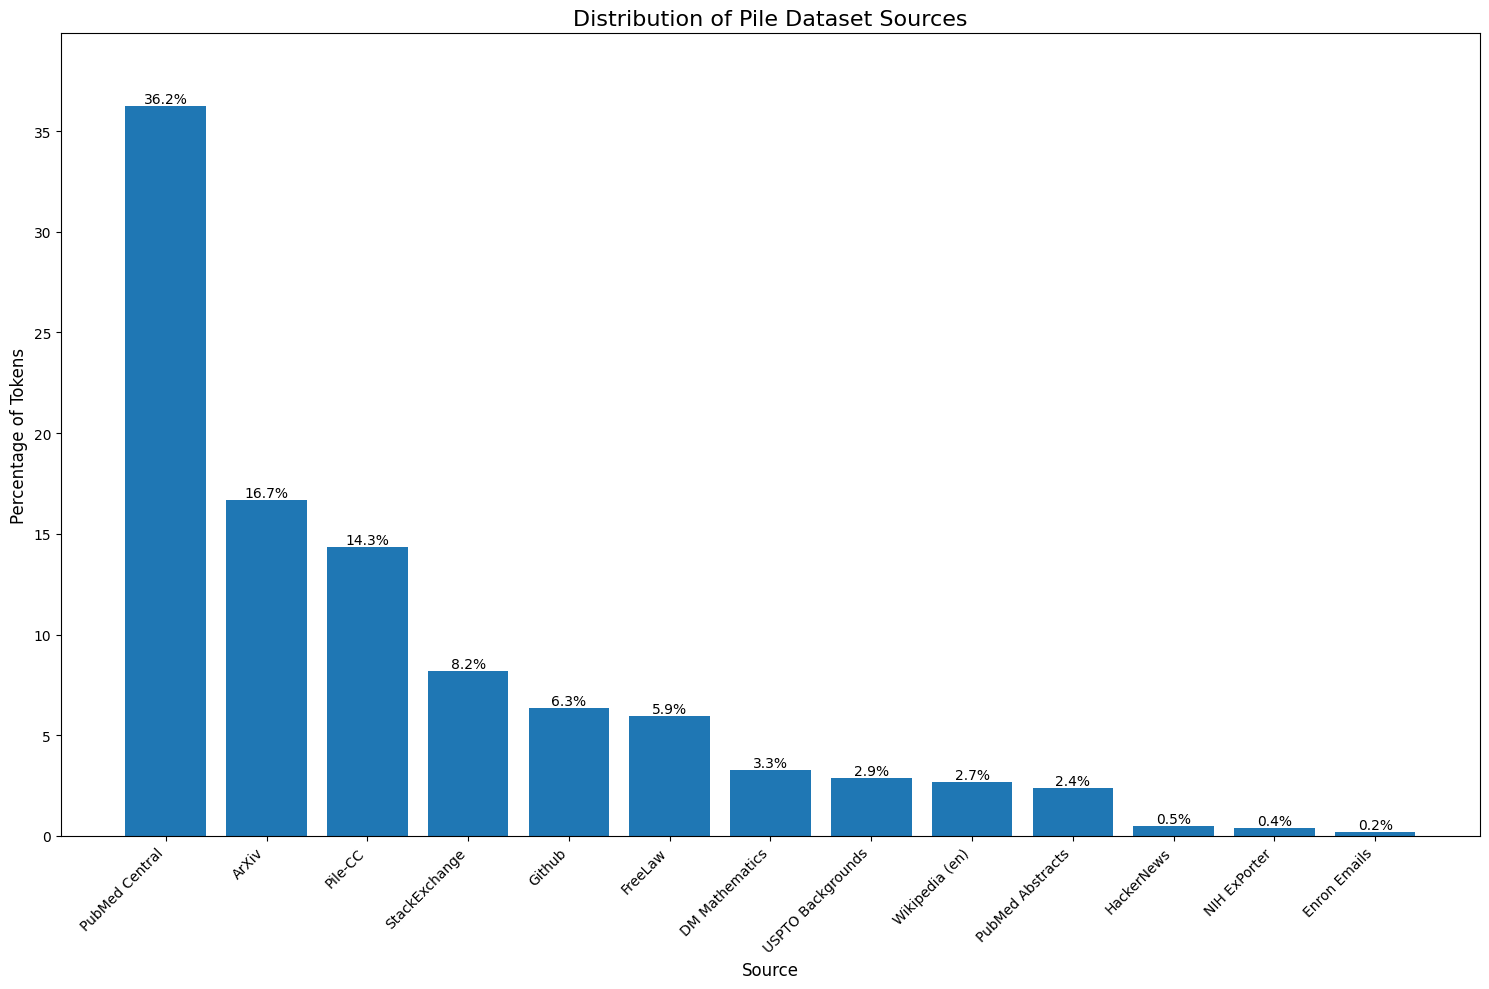

In [37]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

def visualize_distribution(file_path):
    with h5py.File(file_path, 'r') as f:
        distribution = dict(f['distribution'].attrs)
    
    # Sort the distribution by token count
    sorted_distribution = sorted(distribution.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_distribution)

    # Calculate percentages
    total = sum(values)
    percentages = [value / total * 100 for value in values]

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(15, 10))
    bars = ax.bar(labels, percentages)

    # Customize the plot
    ax.set_title('Distribution of Pile Dataset Sources', fontsize=16)
    ax.set_xlabel('Source', fontsize=12)
    ax.set_ylabel('Percentage of Tokens', fontsize=12)
    ax.set_ylim(0, max(percentages) * 1.1)  # Set y-axis limit with some headroom

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Use the function
visualize_distribution(config["output_file"])